In [34]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [35]:
# Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [41]:
def load_complete_model(model_path):
    # Load the dictionary containing model and other info
    checkpoint = torch.load(model_path)
    
    # Create the model architecture
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)
    
    # Load the weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Access other saved information if needed
    class_names = checkpoint['class_names']
    return model, class_names

In [42]:
model_path = "/home/bartek/Kod/PD/praca_dyplomowa/dane/modele/resnet18_code_classifier_complete.pth"

In [43]:
folder_path = "/home/bartek/Kod/PD/praca_dyplomowa/images"  # Folder containing images to classify

In [44]:
model, class_names = load_complete_model(model_path)

/tmp/ipykernel_45155/1740553102.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [45]:
def predict_image(image_path, model, transform, class_names):
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB to handle all image types
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        
        # Get results
        predicted_class = predicted.item()
        predicted_label = class_names[predicted_class]
        confidence = probabilities[predicted_class].item() * 100
        
        return image, predicted_label, confidence
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, "Error", 0

In [46]:
def process_folder(folder_path, model, transform, class_names, extensions=['.jpg', '.jpeg', '.png']):
    # Get all image files in folder and subfolders
    folder = Path(folder_path)
    image_paths = []
    
    for ext in extensions:
        image_paths.extend(list(folder.glob(f'**/*{ext}')))
        image_paths.extend(list(folder.glob(f'**/*{ext.upper()}')))
    
    print(f"Found {len(image_paths)} images")
    
    # Process each image
    results = []
    for path in image_paths:
        image, label, confidence = predict_image(path, model, transform, class_names)
        if image is not None:
            results.append({
                'path': path,
                'image': image,
                'prediction': label,
                'confidence': confidence
            })
    
    return results

In [47]:
results = process_folder(folder_path, model, transform, class_names)

Found 1254 images


/home/bartek/Kod/PD/pd_env/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing /home/bartek/Kod/PD/praca_dyplomowa/images/Analysing_ISFB_–_The_First_Loader/check_arch.png: image file is truncated


In [48]:
code_count = sum(1 for r in results if r['prediction'] == 'code')
no_code_count = sum(1 for r in results if r['prediction'] == 'no_code')
print(f"\nSummary:")
print(f"  - Total images processed: {len(results)}")
print(f"  - Images classified as 'code': {code_count}")
print(f"  - Images classified as 'no_code': {no_code_count}")


Summary:
  - Total images processed: 1253
  - Images classified as 'code': 1079
  - Images classified as 'no_code': 174


In [49]:
results_code = [path for path in results if path["prediction"]=="code"]

In [50]:
results_no_code = [path for path in results if path["prediction"]!="code"]

In [51]:
from IPython.display import display, HTML
import base64
from io import BytesIO

In [52]:
def quick_display(results_list, num_cols=3, thumbnail_size=(200, 200)):
    """
    Quick display of thumbnails with predictions for Jupyter notebooks
    """
    
    html = "<div style='display: flex; flex-wrap: wrap;'>"
    
    for result in results_list:
        # Create thumbnail
        img = result['image'].copy()
        img.thumbnail(thumbnail_size)
        
        # Convert to base64 for HTML embedding
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        # Create HTML for this thumbnail
        html += f"""
        <div style='margin: 10px; text-align: center; width: {thumbnail_size[0]}px;'>
            <img src='data:image/jpeg;base64,{img_str}' style='max-width: 100%;'>
            <div><b>Prediction:</b> {result['prediction']}</div>
            <div><b>Confidence:</b> {result['confidence']:.2f}%</div>
            <div style='font-size: 10px; overflow: hidden; text-overflow: ellipsis;'>{result['path'].name}</div>
        </div>
        """
    
    html += "</div>"
    display(HTML(html))

# Usage: quick_display(results_list)


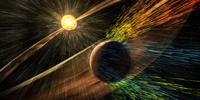
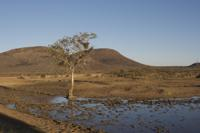
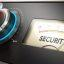
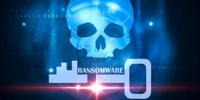
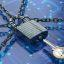
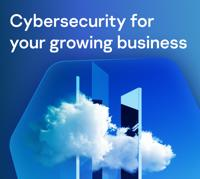
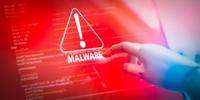
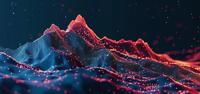
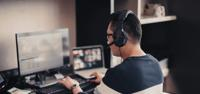
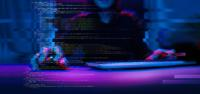
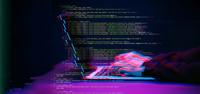
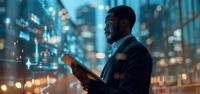
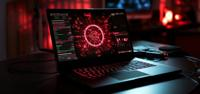
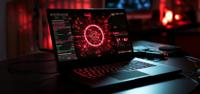
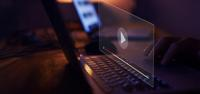
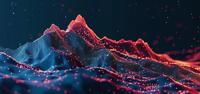
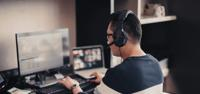
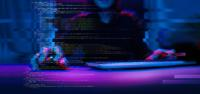
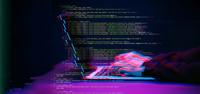
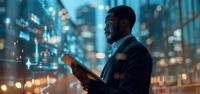
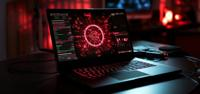
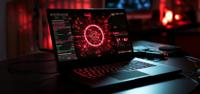
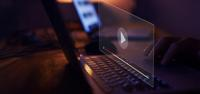
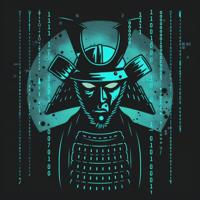
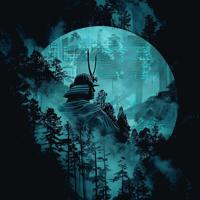
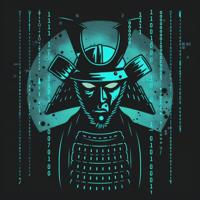
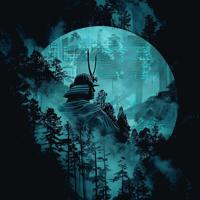
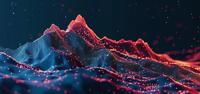
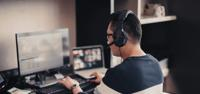
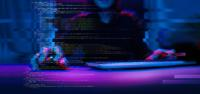
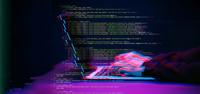
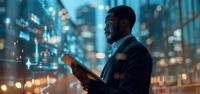
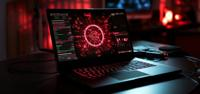
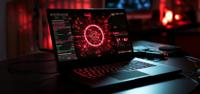
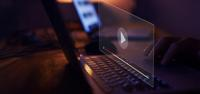
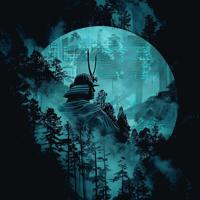
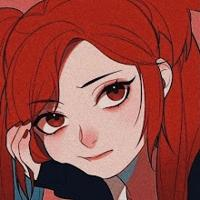
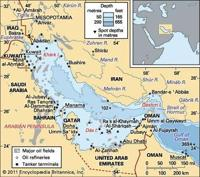
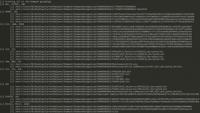
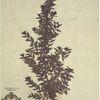
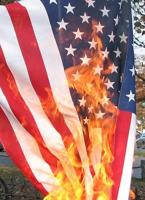
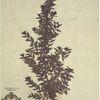
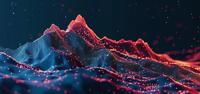
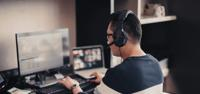
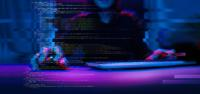
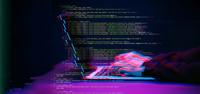
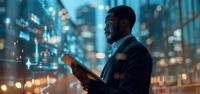
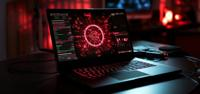
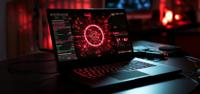
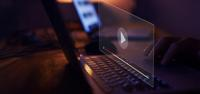
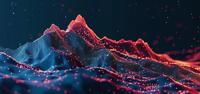
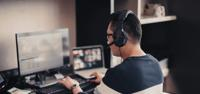
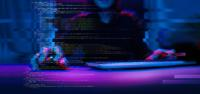
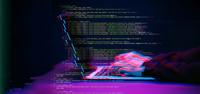
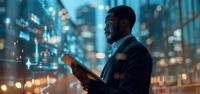
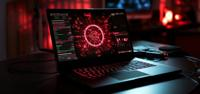
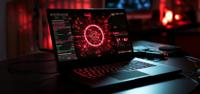
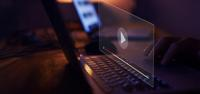
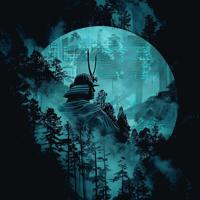
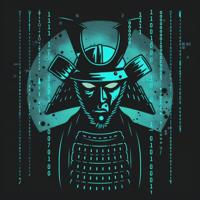
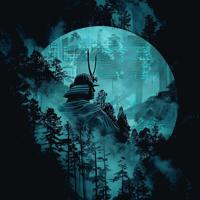
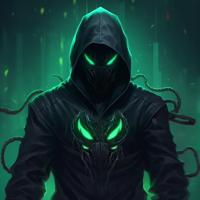
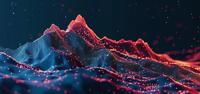
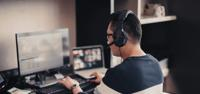
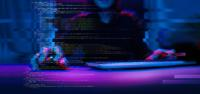
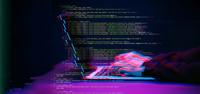
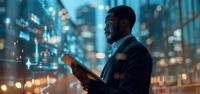
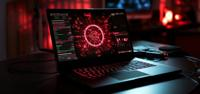
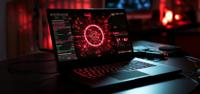
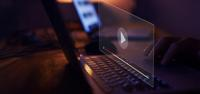
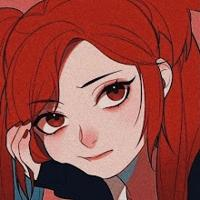
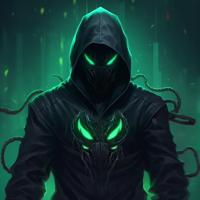
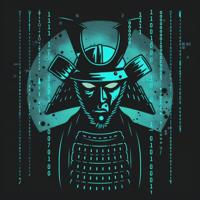
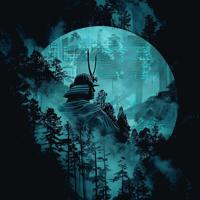
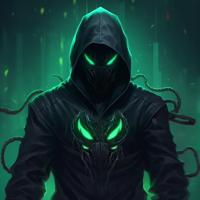
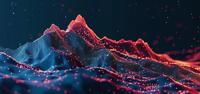
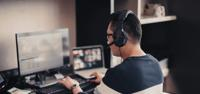
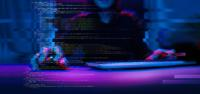
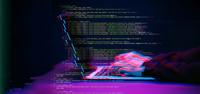
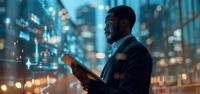
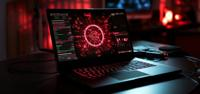
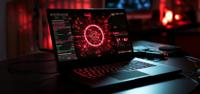
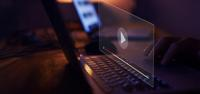
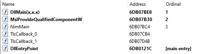
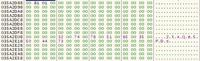
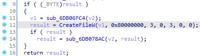
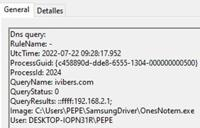
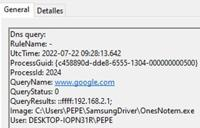
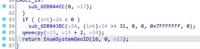
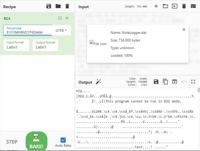
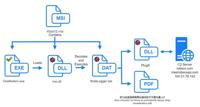
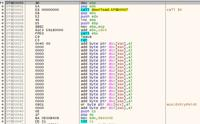
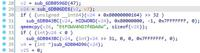
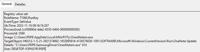
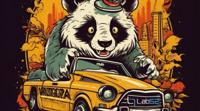
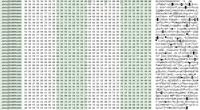
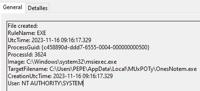
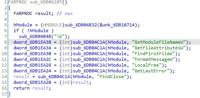
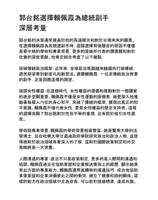

In [53]:
quick_display(results_code[:100])


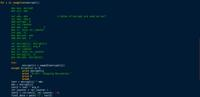
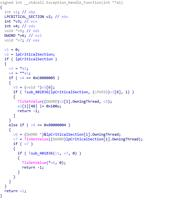
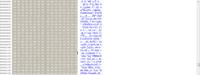
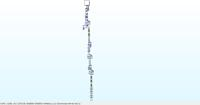
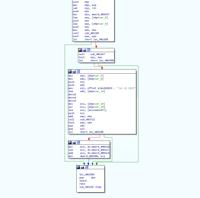
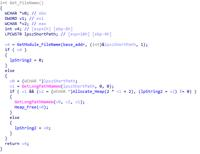
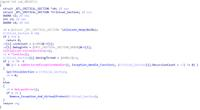
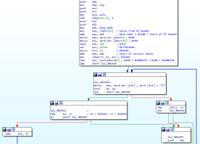
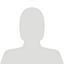
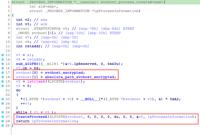
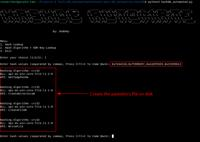
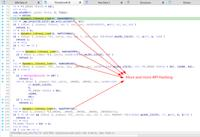
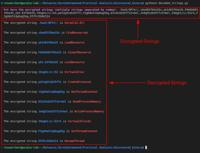
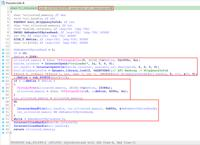
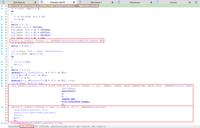
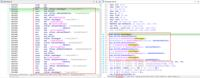
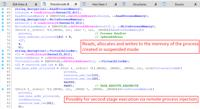
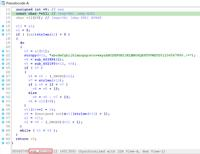
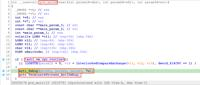
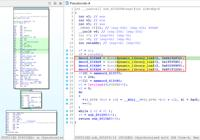
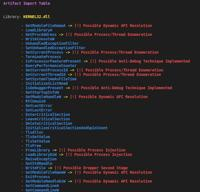
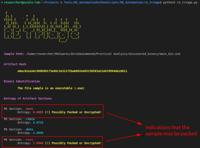
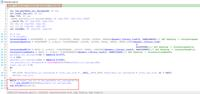
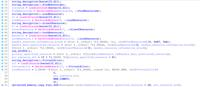
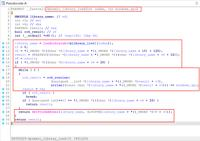
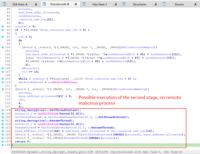
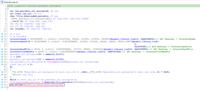
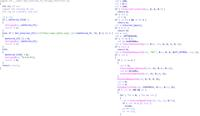
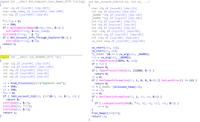
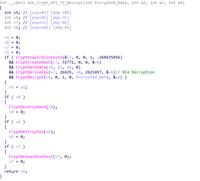
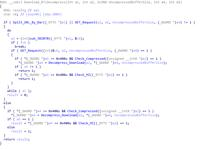
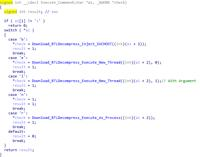
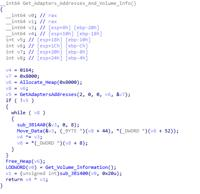
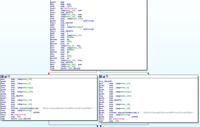
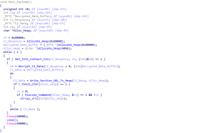
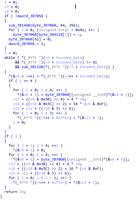
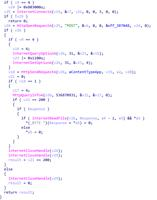
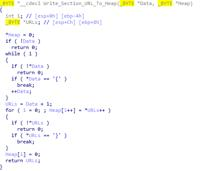
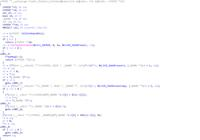
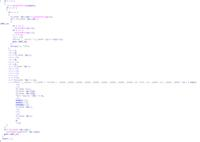
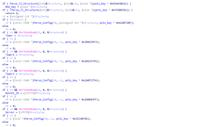
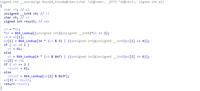
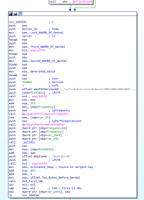
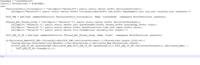
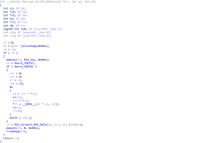
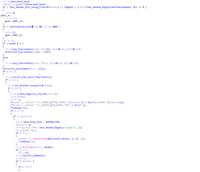
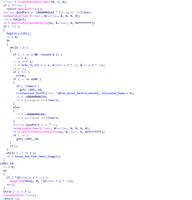
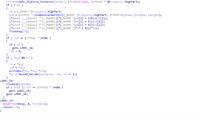
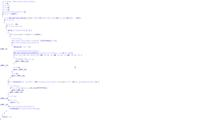
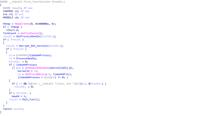
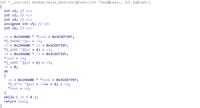
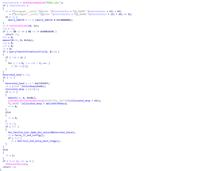
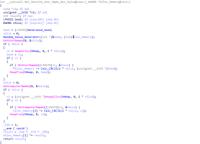
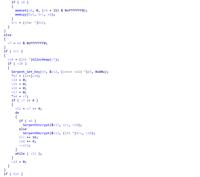
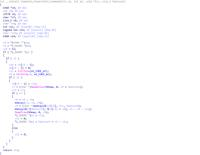
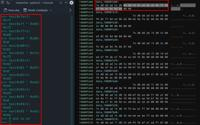
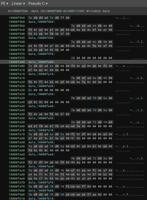
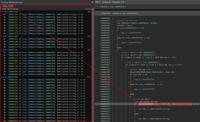
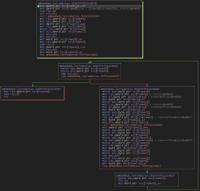
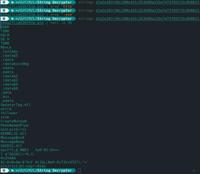
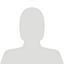
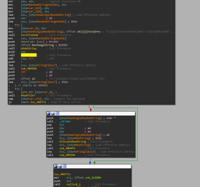
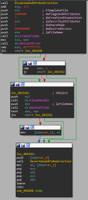
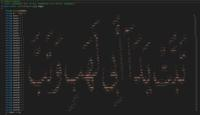
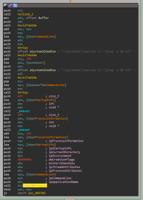
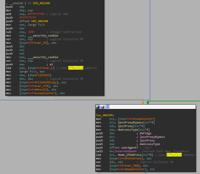
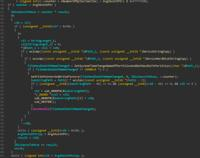
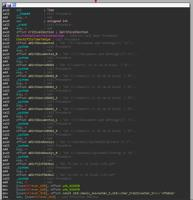
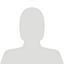
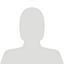
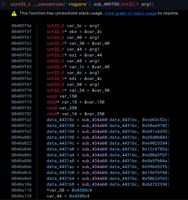
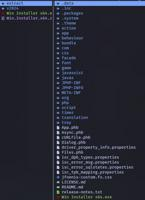
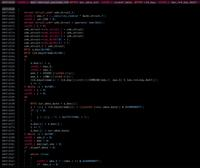
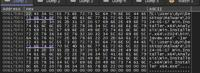
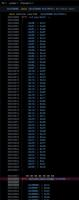
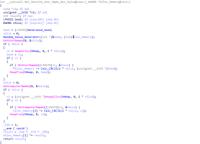
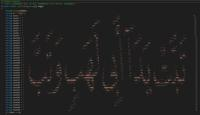
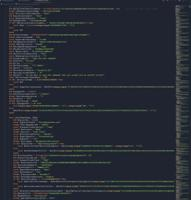
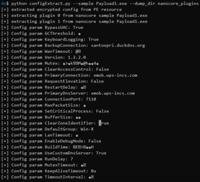
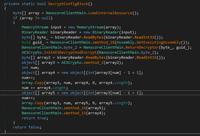
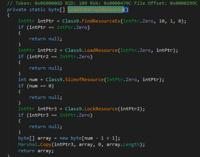
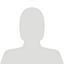
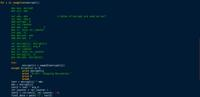
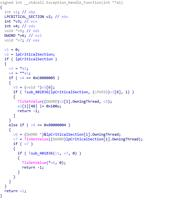
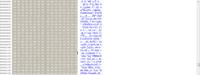
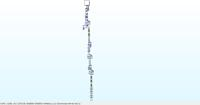
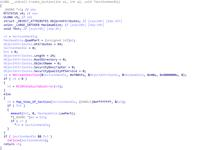
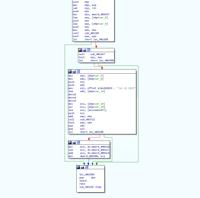
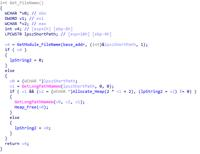
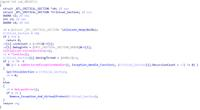
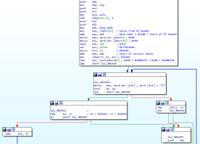
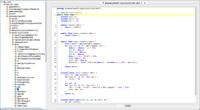
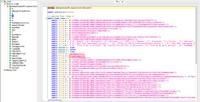
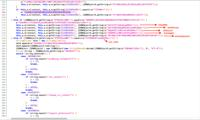
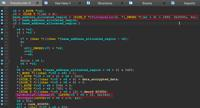
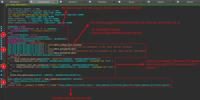
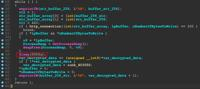
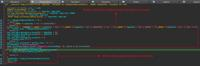
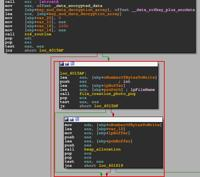
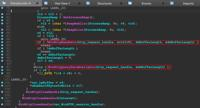

In [54]:
quick_display(results_no_code[:100])